In [1]:
# 📦 Libraries import kar rahe hai – zaroori tools
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import cv2
import time
from IPython.display import display, Image, clear_output


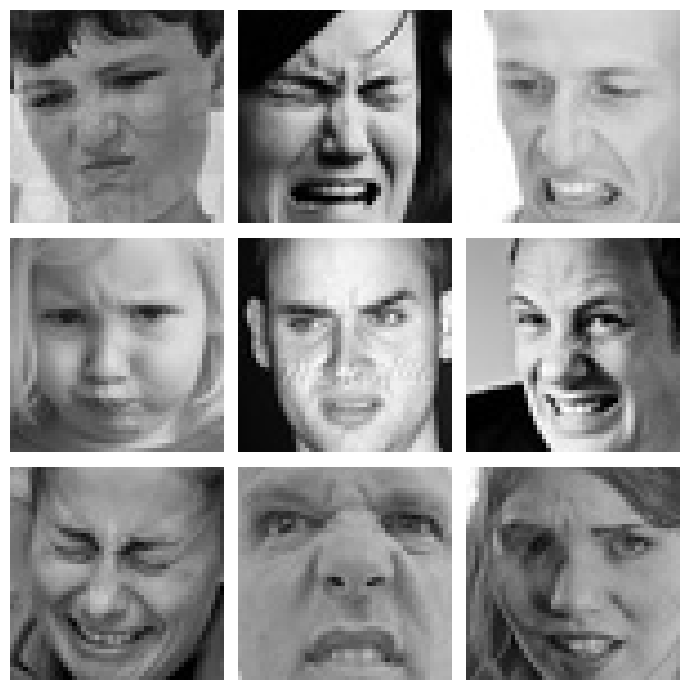

In [2]:
# 📁 Dataset ka folder path set kar rahe hai
folder_path = "C:/Users/LENOVO/Downloads/Face Emotion Recognition Dataset/images/"
picture_size = 48  # Har image ko 48x48 size mein convert karenge

# 👀 Preview ke liye 9 images dikhate hain 'disgust' wale folder se
expression = 'disgust'
plt.figure(figsize=(7, 7))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(folder_path, "train", expression, os.listdir(os.path.join(folder_path, "train", expression))[i])
    img = load_img(img_path, target_size=(picture_size, picture_size))
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
# 🧪 Image generators bana rahe hai data ko load karne aur normalize karne ke liye
datagen_train = ImageDataGenerator(rescale=1./255)  # Normalization
datagen_val = ImageDataGenerator(rescale=1./255)

batch_size = 128

# 📂 Training images load
train_set = datagen_train.flow_from_directory(
    folder_path + "train",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# 📂 Validation images load
test_set = datagen_val.flow_from_directory(
    folder_path + "validation",
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [4]:
# 🎯 Class weights nikal rahe hai taaki model biased na ho sirf 'sad' pe
y_train_labels = train_set.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights))


In [5]:
# 🧠 CNN model design kar rahe hai – image se emotion samajhne ke liye
model = Sequential()

# Layer 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 2
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 3
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Layer 4
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Final layers – flatten karke fully connected bana rahe hai
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer – 7 emotions ke liye softmax
model.add(Dense(7, activation='softmax'))

# 🔧 Compile kar rahe hai model ko – loss, optimizer & accuracy ke sath
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [6]:
# 🧩 Callbacks – training smart banane ke liye
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


In [7]:
# 🔁 Model file already exist karta hai to usko load karenge, warna train karenge
model_path = "model.h5"
history = None  # Declare history initially

if os.path.exists(model_path):
    print("📦 Pre-trained model mil gaya! Load kar rahe hai...")
    model = load_model(model_path)
    print("✅ Model loaded successfully.")
else:
    print("🚀 Model nahi mila, ab training start kar rahe hai...")
    epochs = 48
    history = model.fit(
        train_set,
        steps_per_epoch=train_set.n // train_set.batch_size,
        epochs=epochs,
        validation_data=test_set,
        validation_steps=test_set.n // test_set.batch_size,
        callbacks=callbacks_list,
        class_weight=class_weights  # <- yeh bahut important hai!
    )
    model.save(model_path)
    print("✅ Training complete. Model save ho gaya as 'model.h5'")


📦 Pre-trained model mil gaya! Load kar rahe hai...


✅ Model loaded successfully.


In [8]:
# 📊 Accuracy aur Loss graph sirf tabhi banayenge jab training hui ho
if history:
    plt.style.use('dark_background')
    plt.figure(figsize=(20, 10))

    # Loss graph
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()

    # Accuracy graph
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()

    plt.show()
else:
    print("📉 Training graphs skip kar rahe hai kyunki model pehle se trained tha.")


📉 Training graphs skip kar rahe hai kyunki model pehle se trained tha.


In [21]:
# 📷 Real-time prediction – Webcam se emotion detect karna
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Haar Cascade for face detection
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Webcam start kar rahe hai
cap = cv2.VideoCapture(0)
print("📸 Real-time emotion detection on... Press STOP to quit.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray)

        for (x, y, w, h) in faces:
            roi = gray[y:y+h, x:x+w]
            roi = cv2.resize(roi, (48, 48))
            roi = roi.astype("float") / 255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi, axis=0)

            preds = model.predict(roi, verbose=0)[0]
            label = emotion_labels[preds.argmax()]
            confidence = round(np.max(preds) * 100, 2)

            label_text = f"{label} ({confidence}%)"
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frame, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

        _, jpeg = cv2.imencode('.jpg', frame)
        display(Image(data=jpeg.tobytes()))
        clear_output(wait=True)
        time.sleep(0.05)

except KeyboardInterrupt:
    print("🛑 Real-time detection stopped manually.")

finally:
    cap.release()
    cv2.destroyAllWindows()


🛑 Real-time detection stopped manually.


# To Ab Kya Sudhar Hua?
Emotion prediction bias hat gaya (class weight laga ke).

Duplicate model definition hata diya.




In [23]:

import collections
print("Train labels count:", collections.Counter(y_train_labels))

Train labels count: Counter({3: 7164, 4: 4982, 5: 4938, 2: 4103, 0: 3993, 6: 3205, 1: 436})
